In [2]:
from gymnasium import Env
from gymnasium.spaces.box import Box
import numpy as np
import random
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.noise import NormalActionNoise
import wandb
from wandb.integration.sb3 import WandbCallback
import os
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pickle
import warnings
import math
warnings.filterwarnings("ignore")

# Siguientes pasos
* Ir cambiando estado inicial (primero posición y luego también velocidad y corriente)
* Añadir datos de este año
* Cambiar reward a corriente

In [129]:
class BobinaEnv(Env):
  """
  Custom Gym Environment for the Hybrid Electromagnetic Suspension, considering just one coil.
  """
  def __init__(self, masa_pod = 200, airgap = 10, duration = 10):
    # Actions: Voltage applied to the coil
    self.action_space = Box(low=np.array([-100]), high = np.array([50]), dtype=np.float32)
    # Observations: Airgap to the ceiling, velocity, distance to the objective, current of the coil
    self.observation_space = Box(low=np.array([10, -np.inf, -10, -45]), high = np.array([23, np.inf, 10, 45]), dtype=np.float32)
    # Initial parameters
    self.state = np.array([airgap, 0, airgap - 19.5, 0])
    self.airgapinicial = airgap
    self.duration = duration
    self.timeleft = duration
    self.crash = False
    self.masa_pod = masa_pod
    self.bobina = Bobina(masa_pod = self.masa_pod, airgap = self.airgapinicial)
    self.steps = []
    self.airgap = airgap
    self.distancia = 0
    self.velocidad = 0
    self.current = 0


  def step(self, action):
    # Apply action
    self.state, self.crash = self.bobina.step(action[0])
    self.airgap, self.velocidad, self.distancia, self.current = self.state

    # Reduce the time of the experiment
    self.timeleft -= 0.001

    # Calculate reward
    #reward = -abs(self.distancia)

    if self.airgap >= 23: reward = -500
    elif self.airgap <= 10: reward = -500
    else: reward = -abs(self.current)

    # Check if experiment is done
    if self.timeleft <= 0:
      truncated = True
    else: truncated = False
    # Set placeholder for info
    info = {}
    # Only if we implemented the crash
    if self.crash:
      reward = - 50000
      terminated = True
    else:
      terminated = False
    self.steps.append(self.state)
    return self.state, reward, terminated, truncated, info


  def render(self, yes = "yes"):
    # create data
    x = list(range(0,len(self.steps)))
    y = [step[0] for step in self.steps]
    objective = [19.5]*len(self.steps)

    # plot lines
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors='white')  #setting up Y-axis tick color to black

    plt.plot(x, y, label = "States")
    plt.plot(x, objective, label = "Objective")
    plt.legend()
    plt.show()

  def reset(self, seed = 0):
    # Reset experiment choosing randomly the start (ceiling or floor)
    airgap = random.choice([19.5])
    self.state = self.observation_space.sample()
    self.airgap, self.velocidad, self.distancia, self.current = self.state
    self.bobina = Bobina(masa_pod = self.masa_pod, airgap = self.airgap)
    self.bobina.velocidad = [self.velocidad]
    self.bobina.aceleracion = [random.choice(list(range(-50, 50, 2)))/10]
    # Reset time
    self.timeleft = self.duration
    self.crash = False
    self.steps = []
    return self.state, seed

In [119]:
class Bobina():
  """ 
  Coil model for the Hybrid Electromagnetic Suspension
  """
  def __init__(self, masa_pod = 200, airgap = 23):
    self.masa_pod = masa_pod
    self.airgap = airgap
    self.aceleracion = []
    self.velocidad = []
    mat = scipy.io.loadmat('./coil/hems.mat')
    self.hems = mat["hems"][0][0]
    self.airgaps = self.hems[0][0]
    self.currents = self.hems[1][0]
    self.force_vertical = pickle.load(open("./coil/mlp_vertical.pkl", 'rb'))
    self.flux = self.hems[3]
    self.force_horizontal = self.hems[4]
    self.inductance = pickle.load(open("./coil/rf_inductance.pkl", 'rb'))
    self.resistance = self.hems[6][0][0]
    self.min_distance = self.airgaps[0]
    self.max_distance = self.airgaps[-1]
    self.airgapinicial = airgap
    self.crash = False
    self.current = 0
    self.steps_RL = []

  def integral(self, lista, h = 1):
    return sum(h*(lista[i]+lista[i+1])/2 for i in range(len(lista)-1))

  def RL(self, airgap, target_voltage, temperature):
    # Resistance-Inductance circuit

    # Get resistance of the coil
    R = self.R(current = self.current, temperature = temperature)   
    V = target_voltage
    I = self.current
    L = self.L(airgap = airgap, current = self.current)
    dIdt = ((V/R) - I)/(L/R)                                      
    self.steps_RL.append(dIdt)                                   
    current = self.integral(self.steps_RL, h = 0.001)                          
    return current                                                  

  def R(self, current, temperature):
    return self.resistance                                         

  def L(self, airgap, current):
    # Return predicted inductance
    return float(self.inductance.predict(np.array([[airgap, current]]))[0])

  def vertical_force(self, airgap, target_voltage, temperature):
    # Get current from RL circuit
    I = self.RL(airgap = airgap, target_voltage = target_voltage, temperature = temperature) 
    
    # Clip result
    if I > 45:
      I = 45
    elif I < -45:
      I = -45
    self.current = I
    # Get vertical force from 
    FI = self.FI_vertical(airgap = airgap, current = I)                    
    return FI, I


  def FI_vertical(self, airgap, current):
    # Return predicted vertical force
    return float(self.force_vertical.predict(np.array([[airgap, current]])))    


  def next_airgap(self, masa_pod, vertical_force, verbose = False):
    # Devide the mass of the pod by 4 coils
    masa = masa_pod/4  
    # Calculate weight
    peso = masa * 9.8    
    # Get total force                                                       
    fuerza = peso - vertical_force
    if verbose: print("Fuerza resultante: ", fuerza)   
    # Calculate acceleration                                     
    aceleracion = fuerza/masa
    if verbose: print("Aceleración: ", aceleracion)                                         
    self.aceleracion.append(aceleracion)       
    # Calculate velocity                                
    velocidad = self.integral(self.aceleracion, 0.001)
    if verbose: print("Integral primera (velocidad): ", velocidad)                          
    self.velocidad.append(velocidad)               
    # Calculate position (x1000 as to transform from m to mm)                            
    posicion = self.airgapinicial + self.integral(self.velocidad, 0.001)*1000 
    if verbose: print("Integral segunda (posición): ", posicion)

    # Clip position
    if posicion > self.max_distance:
      airgap = self.max_distance
      self.aceleracion = [0]
      self.velocidad = [0]  
      #self.crash = True     
      self.airgapinicial = self.max_distance                                               
    elif posicion < self.min_distance:
      airgap = self.min_distance
      self.aceleracion = [0]
      self.velocidad = [0]
      #self.crash = True
      self.airgapinicial = self.min_distance
    else: airgap = posicion
    return airgap, velocidad

  def step(self, target_voltage, verbose = False):
    # Calculate vertical force and current
    vertical_force, self.current = self.vertical_force(airgap = self.airgap, target_voltage = target_voltage, temperature = 40)
    if verbose: print("Fuerza vertical: ", vertical_force)
    # Calculate next airgap and velocity
    self.airgap, velocidad = self.next_airgap(self.masa_pod, vertical_force, verbose = verbose)
    #noise = np.random.normal(0,0.5)
    #self.airgap = self.airgap + noise     
    return (np.float32(self.airgap), np.float32(velocidad), np.float32(self.airgap - 19.5), np.float32(self.current)), self.crash

In [98]:
run = wandb.init(
    project="1gdlcomplex",
    sync_tensorboard=True,
    monitor_gym=True,
)

SAC_21/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
SAC_21/rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_21/rollout/ep_rew_mean,▁▅▇▇▇█████████████████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄
SAC_21/time/fps,▁▁██████████████████████████████████████
SAC_21/train/actor_loss,▁▁▁▁▂▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
SAC_21/train/critic_loss,▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁
SAC_21/train/ent_coef,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
SAC_21/train/ent_coef_loss,▃▄▃▄▃▃▁▂▂▂▁▂▁▂▁▂▂▃▂▂▂▂▂▃▃▄▃▅▃▄▄▄▄▅▆▆▆▆▆█
SAC_21/train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
rollout/ep_len_mean,▁▁▁▁


In [99]:
# Create log dir
log_dir = "1gdlcomplex/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = BobinaEnv( duration = 4 )
env = Monitor(env, log_dir)

In [113]:
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

# para el critic , qf=[400, 300], para el actor pi=[300, 200]
policy_kwargs = dict(net_arch=dict(pi=[8, 8], qf=[256, 256]))

MODEL_PATH = f"models/sac8x8/model.zip"
model = SAC.load(MODEL_PATH, env=env, learning_rate = linear_schedule(0.000000001))
#model = SAC("MlpPolicy", env,learning_rate = linear_schedule(0.0001),  policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [110]:
# Create checkpoint callback
checkpoint_callback = CheckpointCallback(
    save_freq=10000, save_path=log_dir, name_prefix="rl_sac_1gdlcomplex"
)

In [114]:
# Train the agent
model.learn(total_timesteps=600000,
    callback=[
        checkpoint_callback,
        WandbCallback(
            gradient_save_freq=10000,
            model_save_path=f"models/sac8x8finetunecurrent",
            model_save_freq=10000,
            verbose=2,
        ),
    ],
)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Logging to 1gdlcomplex/SAC_33


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4e+03     |
|    ep_rew_mean     | -6.78e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 36        |
|    time_elapsed    | 433       |
|    total_timesteps | 16004     |
| train/             |           |
|    actor_loss      | 4.94      |
|    critic_loss     | 2.9e+03   |
|    ent_coef        | 0.0186    |
|    ent_coef_loss   | -2.93     |
|    learning_rate   | 9.73e-10  |
|    n_updates       | 945802    |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 4e+03     |
|    ep_rew_mean     | -4.41e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 36        |
|    time_elapsed    | 873       |
|    total_timesteps | 32008     |
| train/             |           |
|    actor_loss      | 2.9       |
|    critic_loss    

In [73]:
episodes = 3
state, seed = env.reset()
for episode in range(1, episodes+1):
    state, seed = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-1981494.4585288865
Episode:2 Score:-1979754.8377862521
Episode:3 Score:-1983431.8486917282


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Time predict 3.0881693363189697
Time model 44.24721097946167
Episode reward -2043.6848680780968
[0.0, -0.6866499, 0.8129981, 2.3017313, 3.7478883, 5.1527286, 6.514825, 7.8427734, 9.150561, 10.422791, 11.653112, 12.850898, 14.011633, 15.127063, 16.199724, 17.23342, 18.228271, 19.18597, 20.110594, 21.005804, 21.871029, 22.706669, 23.51242, 24.279646, 24.998545, 25.668108, 26.28869, 26.856657, 27.374493, 27.84778, 28.27957, 28.670805, 29.02233, 29.334265, 29.605913, 29.836575, 30.025515, 30.171797, 30.273893, 30.329935, 30.337606, 30.294254, 30.196955, 30.042597, 29.828005, 28.5011, 25.02601, 21.014439, 18.679344, 17.477795, 15.510484, 12.625476, 10.0313015, 8.257483, 6.762875, 4.988062, 3.0579112, 1.3199235, -0.12619786, -1.2121214, -1.9174783, -2.4782429, -3.149884, -3.8831782, -4.469115, -4.9486785, -5.5183306, -6.1473393, -6.61802, -6.8874583, -7.1491513, -7.493901, -7.762799, -7.9663033, -8.253805, -8.545967

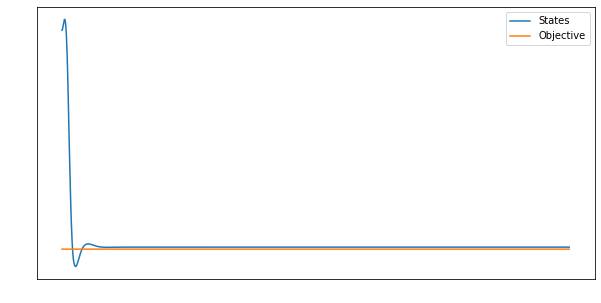

Time predict 3.0942277908325195
Time model 44.625184297561646
Episode reward -1752.7152185793966
[0.0, -0.74520284, -3.7079558, -6.501114, -9.070125, -11.466333, -13.718774, -15.832576, -17.809164, -19.636738, -21.291897, -22.74678, -23.96128, -24.896694, -25.48376, -25.223003, -24.082958, -22.779694, -21.702333, -20.89738, -20.241554, -19.61618, -18.994947, -18.407137, -17.879532, -17.415375, -16.999899, -16.617783, -16.262724, -15.933053, -15.625535, -15.333968, -15.0499115, -14.770706, -14.502167, -14.243452, -13.980795, -13.702702, -13.409564, -13.105171, -12.791863, -12.473, -12.153642, -11.839797, -11.533838, -11.232914, -10.932992, -10.63361, -10.3371725, -10.042971, -9.750386, -9.460305, -9.170839, -8.884367, -8.608301, -8.345492, -8.092464, -7.846112, -7.6064196, -7.3727407, -7.1432567, -6.9192915, -6.702999, -6.478691, -6.2408423, -6.019227, -5.8466654, -5.7339582, -5.6072536, -5.2707396, -4.7317295, -4.242566, -3.915761, -3.66893, -3.3917909, -3.0674112, -2.7469716, -2.46694

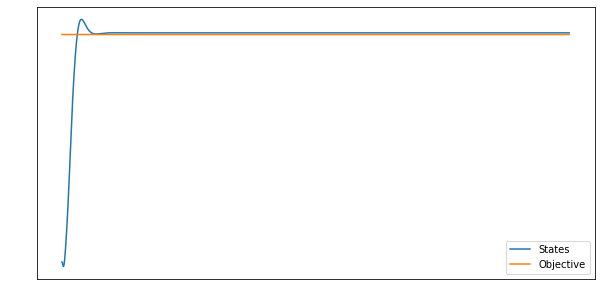

Time predict 3.076265335083008
Time model 44.442145109176636
Episode reward -2306.0568254019017
[0.0, 0.37787127, 1.8621424, 3.320203, 4.735566, 6.1083293, 7.4406395, 8.735025, 10.007994, 11.258206, 12.467873, 13.63346, 14.76203, 15.853978, 16.905989, 17.918623, 18.890621, 19.823645, 20.723158, 21.592909, 22.437485, 23.247627, 24.019741, 24.7591, 25.462385, 26.126919, 26.751032, 27.335747, 27.880207, 28.385077, 28.850864, 29.278353, 29.671158, 30.032482, 30.362057, 30.660425, 30.929022, 31.16816, 31.378183, 31.558731, 31.70934, 31.828867, 31.915514, 31.967377, 31.982119, 31.956936, 31.888563, 31.773298, 31.607073, 31.385523, 31.104698, 29.187004, 24.940882, 20.826214, 18.645258, 17.283335, 14.902776, 11.770746, 9.127801, 7.2695127, 5.6002736, 3.677869, 1.6583731, -0.11076145, -1.489867, -2.3869257, -3.0117855, -3.7774487, -4.617729, -5.2873435, -5.83189, -6.4577518, -7.0900183, -7.4958687, -7.72451, -8.024813, -8.410747, -8.747293, -9.104938, -9.522148, -9.815647, -9.920341, -9.980563,

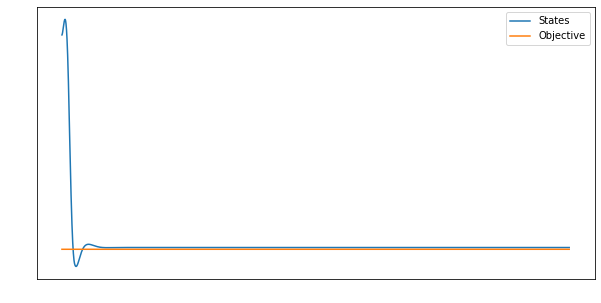

Time predict 3.0823755264282227
Time model 44.44202923774719
Episode reward -1934.6536145401187
[0.0, -2.9427507, -5.81675, -8.44873, -10.900405, -13.193384, -15.342632, -17.364843, -19.249575, -20.980093, -22.535925, -23.881985, -24.977509, -25.791546, -26.314314, -26.438334, -25.857672, -24.705566, -23.520365, -22.557396, -21.81004, -21.161901, -20.527828, -19.901106, -19.315311, -18.794369, -18.335686, -17.922388, -17.5408, -17.186728, -16.85954, -16.558577, -16.28196, -16.025438, -15.785971, -15.561105, -15.345091, -15.129764, -14.910267, -14.689743, -14.476385, -14.271232, -14.062478, -13.8398285, -13.602671, -13.354489, -13.096814, -12.829307, -12.553448, -12.274166, -11.996343, -11.722592, -11.453205, -11.184931, -10.916453, -10.649181, -10.383425, -10.117468, -9.851161, -9.586166, -9.322396, -9.059498, -8.802228, -8.556336, -8.320917, -8.091156, -7.864933, -7.643578, -7.427378, -7.214236, -7.003574, -6.798238, -6.596711, -6.3862767, -6.168876, -5.9744463, -5.829453, -5.7368965,

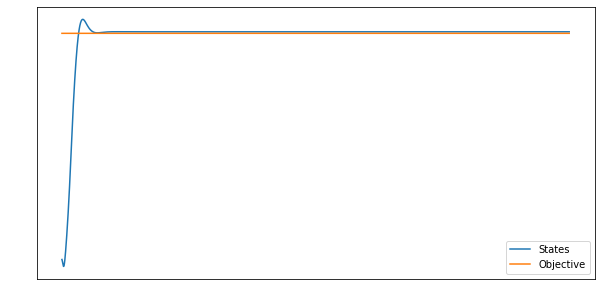

Time predict 3.06994366645813
Time model 44.61245918273926
Episode reward -1416.3869739557267
[0.0, -0.7349412, -3.6612868, -6.435078, -9.015335, -11.425905, -13.679108, -15.794023, -17.770939, -19.590025, -21.216864, -22.609673, -23.26155, -22.647898, -21.283928, -19.942728, -18.88196, -18.096308, -17.465433, -16.878086, -16.2998, -15.7487955, -15.244686, -14.787576, -14.356848, -13.921377, -13.463929, -12.987531, -12.505396, -12.033406, -11.577031, -11.13456, -10.702319, -10.277897, -9.859454, -9.447781, -9.044829, -8.649867, -8.265806, -7.8966947, -7.548688, -7.2230287, -6.8935857, -6.432439, -5.775389, -5.091345, -4.582204, -4.282327, -4.0500913, -3.7539058, -3.4030921, -3.0685987, -2.783607, -2.529294, -2.2756386, -2.0293484, -1.9002702, -1.8865, -1.7957435, -1.5905119, -1.3845544, -1.236615, -1.1095866, -0.94720495, -0.7671259, -0.6191717, -0.49960896, -0.36552918, -0.2114752, -0.07247615, 0.04044843, 0.1542123, 0.2837475, 0.40997913, 0.51665, 0.6168483, 0.72638345, 0.8371243, 0.

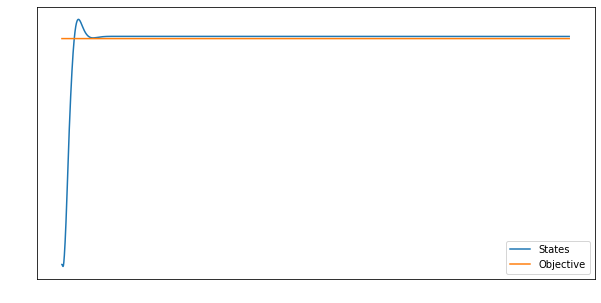

: 

In [131]:
import numpy as np
import torch as th
import time

MODEL_PATH = f"models/sac8x8finetunecurrent/model.zip"

# Create and wrap the environment
env = BobinaEnv(duration = 4)

# Load the trained agent
model = SAC.load(MODEL_PATH, env=env, learning_rate = 0.00001)

# Evaluate the agent
for i in range(5):
    obs, seed = env.reset()
    done = False
    episode_reward = 0
    velocidad = 0
    current = 0
    observations = []
    noises = []
    error = obs -19.5
    timepredict = 0
    timemodel = 0
    obs, velocidad, error, current = obs
    while not done:
        #noise = random.uniform(-1, 1)
        #obs = obs + noise
        observations.append(obs)
        #noises.append(noise)
        t1 = time.time()
        action, _states = model.predict(np.array([obs, velocidad, error, current]), deterministic=True)
        t2 = time.time()
        #print(action)
        #if env.airgap > 10.1: action = max(action, [-50])
        #print(action)
        t3 = time.time()
        state, reward, terminated, truncated, info = env.step(np.array(action))
        t4 = time.time()
        obs, velocidad, error, current = state
        done = truncated or terminated
        episode_reward += reward
        timepredict += t2 - t1
        timemodel += t4 - t3
        noises.append(current)
    print("Time predict", timepredict)
    print("Time model", timemodel)
    print("Episode reward", episode_reward)
    print(noises)
    env.render("yes")

In [10]:
run.id

NameError: name 'run' is not defined

In [96]:
import torch as th

from stable_baselines3 import SAC

#import onnx
import onnxruntime as ort
import numpy as np


class OnnxablePolicy(th.nn.Module):
    def __init__(self, actor: th.nn.Module):
        super().__init__()
        # Removing the flatten layer because it can't be onnxed
        self.actor = th.nn.Sequential(
            actor.latent_pi,
            actor.mu,
            # For gSDE
            # th.nn.Hardtanh(min_val=-actor.clip_mean, max_val=actor.clip_mean),
            # Squash the output
            th.nn.Tanh(),
        )

    def forward(self, observation: th.Tensor) -> th.Tensor:
        # NOTE: You may have to process (normalize) observation in the correct
        #       way before using this. See `common.preprocessing.preprocess_obs`
        return self.actor(observation)


# Example: model = SAC("MlpPolicy", "Pendulum-v1")
model = SAC.load(f"models/{run.id}/model.zip", device="cpu")
onnxable_model = OnnxablePolicy(model.policy.actor)

observation_size = model.observation_space.shape
dummy_input = th.randn(1, *observation_size)
th.onnx.export(
    onnxable_model,
    dummy_input,
    "1gdlComplex8x8.onnx",
    opset_version=9,
    input_names=["input"],
)

##### Load and test with onnx

import onnxruntime as ort
import numpy as np

onnx_path = "1gdlComplex8x8.onnx"

observation = np.zeros((1, *observation_size)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
action = ort_sess.run(None, {"input": observation})

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [12]:
model.policy

SACPolicy(
  (actor): Actor(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (latent_pi): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
    )
    (mu): Linear(in_features=8, out_features=1, bias=True)
    (log_std): Linear(in_features=8, out_features=1, bias=True)
  )
  (critic): ContinuousCritic(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (qf0): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (qf1): Sequential(
      (0): Linear(in_features=5, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
   

In [ ]:
# See "ONNX export" for imports and OnnxablePolicy
jit_path = "1gdlComplex.pt"

# Trace and optimize the module
traced_module = th.jit.trace(onnxable_model.eval(), dummy_input)
frozen_module = th.jit.freeze(traced_module)
frozen_module = th.jit.optimize_for_inference(frozen_module)
th.jit.save(frozen_module, jit_path)

##### Load and test with torch

import torch as th

dummy_input = th.randn(1, *observation_size)
loaded_module = th.jit.load(jit_path)
action_jit = loaded_module(dummy_input)